# TP 1: Bayesian Linear Regression

During this session, we will work with Bayesian Linear Regression models with varying basis functions (linear, polynomial and Gaussian). Datasets used are 1D toy regression samples ranging from linear datasets to more complex non-linear datasets such as increasing sinusoidal curves.

**Goal**: Take hand on simple Bayesian models, understand how it works, gain finer insights on predictive distribution.



In [ ]:
#@title Import libs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#@title Useful plot function
# Useful function: plot results
def plot_results(X_train, y_train, X_test, y_test, y_pred, std_pred,
                 xmin=-2, xmax=2, ymin=-2, ymax=1, stdmin=0.30, stdmax=0.45):
    """Given a dataset and predictions on test set, this function draw 2 subplots:
    - left plot compares train set, ground-truth (test set) and predictions
    - right plot represents the predictive variance over input range
    
    Args:
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      X_test: (array) test inputs, sized [N,]
      y_test: (array) test labels, sized [N, ]
      y_pred: (array) mean prediction, sized [N, ]
      std_pred: (array) std prediction, sized [N, ]
      xmin: (float) min value for x-axis on left and right plot
      xmax: (float) max value for x-axis on left and right plot
      ymin: (float) min value for y-axis on left plot
      ymax: (float) max value for y-axis on left plot
      stdmin: (float) min value for y-axis on right plot
      stdmax: (float) max value for y-axis on right plot
      
    Returns:
      None
    """
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = ymin, ymax = ymax)
    plt.plot(X_test, y_test, color='green', linewidth=2,
             label="Ground Truth")
    plt.plot(X_train, y_train, 'o', color='blue', label='Training points')
    plt.plot(X_test, y_pred, color='red', label="BLR Poly")
    plt.fill_between(X_test, y_pred-std_pred, y_pred+std_pred, color='indianred', label='1 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*2, y_pred-std_pred, color='lightcoral')
    plt.fill_between(X_test, y_pred+std_pred*1, y_pred+std_pred*2, color='lightcoral', label='2 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*3, y_pred-std_pred*2, color='mistyrose')
    plt.fill_between(X_test, y_pred+std_pred*2, y_pred+std_pred*3, color='mistyrose', label='3 std. int.')
    plt.legend()

    plt.subplot(122)
    plt.title("Predictive variance along x-axis")
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = stdmin, ymax = stdmax)
    plt.plot(X_test, std_pred**2, color='red', label="\u03C3² {}".format("Pred"))

    # Get training domain
    training_domain = []
    current_min = sorted(X_train)[0]
    for i, elem in enumerate(sorted(X_train)):
        if elem-sorted(X_train)[i-1]>1:
            training_domain.append([current_min,sorted(X_train)[i-1]])
            current_min = elem
    training_domain.append([current_min, sorted(X_train)[-1]])
    
    # Plot domain
    for j, (min_domain, max_domain) in enumerate(training_domain):
        plt.axvspan(min_domain, max_domain, alpha=0.5, color='gray', label="Training area" if j==0 else '')
    plt.axvline(X_train.mean(), linestyle='--', label="Training barycentre")   
    
    plt.legend()
    plt.show()

## Part I: Linear Basis function model

We start with a linear dataset where we will analyze the behavior of linear basis functions in the framework of Bayesian Linear Regression.

In [ ]:
#@title Hyperparameters for linear model { form-width: "30%" }

SIG = 0.2 #@param
ALPHA = 2.0 #@param
NB_POINTS =25 #@param

In [ ]:
# Generate linear toy dataset
def f_linear(x, noise_amount, sigma):
    y = -0.3 + 0.5*x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount*noise

# Create training and test points
dataset_linear = {}
dataset_linear['X_train'] = np.random.uniform(0, 2, NB_POINTS)
dataset_linear['y_train'] = f_linear(dataset_linear['X_train'], noise_amount=1, sigma=SIG)
dataset_linear['X_test'] = np.linspace(-10,10, 10*NB_POINTS)
dataset_linear['y_test'] = f_linear(dataset_linear['X_test'], noise_amount=0, sigma=SIG)
dataset_linear['ALPHA'] = ALPHA
dataset_linear['BETA'] = 1/(2.0*SIG**2)

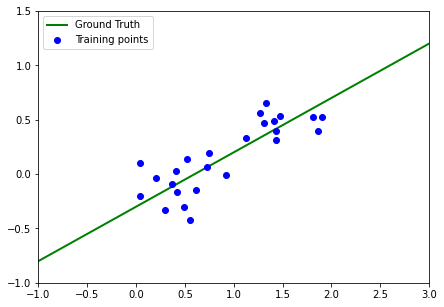

In [ ]:
# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmax = 3, xmin =-1)
plt.ylim(ymax = 1.5, ymin = -1)
plt.plot(dataset_linear['X_test'], dataset_linear['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_linear['X_train'], dataset_linear['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

We will use the linear basis function:
$ \phi:x \rightarrow 
    \begin{pmatrix} 
    1 \\ x 
    \end{pmatrix} 
$

Design matrix $\Phi$ defined on training set $\mathcal{D}=\{(x_n, y_n)\}_{n=1}^N$ is:
$$ \Phi=
  \begin{pmatrix}
    \phi(x_1)^T \\
    ... \\
    \phi(x_N)^T
  \end{pmatrix} =
  \begin{pmatrix}
    1 & x_1 \\
    ... & ...\\
    1 & x_N
  \end{pmatrix}
$$

In [ ]:
#@title **[CODING TASK]** Define the linear basis function

def phi_linear(x):
    """ Linear Basis Functions 
    
    Args:
      x: (float) scalar input
      
    Returns:
      (1D array) linear features of x
    """
    # ============ YOUR CODE HERE ============
    return np.array([1,x])

**[Question 1.1] Recall closed form of the posterior distribution in linear case.**

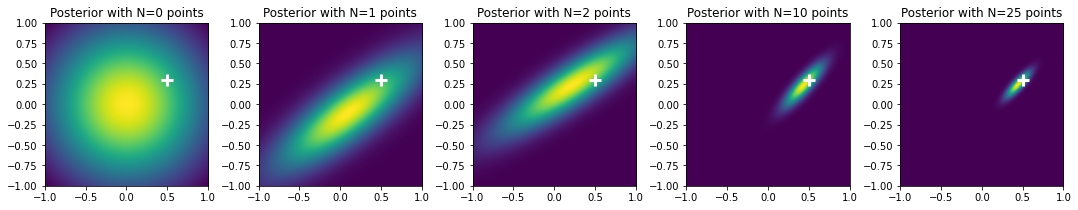

In [ ]:
#@title **[CODING TASK]** Compute mu and sigma to visualize posterior sampling

plt.figure(figsize=(15,7))
for count,n in enumerate([0,1,2,10,len(dataset_linear['X_train'])]):
    cur_data = dataset_linear['X_train'][:n]
    cur_lbl = dataset_linear['y_train'][:n]
    meshgrid = np.arange(-1, 1.01, 0.01)
    w = np.zeros((2,1))
    posterior = np.zeros((meshgrid.shape[0],meshgrid.shape[0]))
    
    # ============ YOUR CODE HERE ============
    # Compute sigma and mu
    # Don't forget the special case of zero data 
    # points, i.e prior
    if n==0:
      sigmainv = dataset_linear['ALPHA']*np.eye(2)
      sigma = np.linalg.inv(sigmainv)
      mu= np.zeros(2)
    else:
      phi = np.array([phi_linear(i) for i in cur_data])
      sigmainv = dataset_linear['ALPHA']*np.eye(2)+dataset_linear['BETA']*phi.T@phi
      sigma = np.linalg.inv(sigmainv)
      mu =dataset_linear['BETA']*sigma@phi.T@cur_lbl

    # Compute values on meshgrid
    for i in range(meshgrid.shape[0]):
        for j in range(meshgrid.shape[0]):
            w[0,0] = meshgrid[i]
            w[1,0] = meshgrid[j]
            posterior[i,j] = np.exp(-0.5* np.dot(np.dot((w-mu.reshape(2,1)).T, sigmainv) , (w-mu.reshape(2,1)) ) ) 
    Z = 1.0 / ( np.sqrt(2*np.pi* np.linalg.det(sigma) ) )
    posterior[:,:] /= Z
    
    # Plot posterior with n points
    plt.subplot(151+count)
    plt.imshow(posterior, extent=[-1,1,-1,1])
    plt.plot(0.5,0.3, '+', markeredgecolor='white', markeredgewidth=3, markersize=12)
    plt.title('Posterior with N={} points'.format(n))

plt.tight_layout()
plt.show()

**[Question 1.2] Looking at the visualization of the posterior above, what can you say?**

at the start we dont have a good estimation of the real w so we can see a real gaussian. The white cross look like the real center of the gaussian because our gaussian seems to center itself arround the cross. ( nous avons construit comme une gaussienne des le depart d'ou le fait que ce soit une gaussienne)

**[Question 1.3] Recall the closed form of the predictive distribution in linear case.**

In [ ]:
#@title **[CODING TASK]** Closed form solution according to the requirements on the left { form-width: "20%" }

def closed_form(func, X_train, y_train, alpha, beta):
    """Define analytical solution to Bayesian Linear Regression, with respect to the basis function chosen, the
    training set (X_train, y_train) and the noise precision parameter beta and prior precision parameter alpha chosen.
    It should return a function outputing both mean and std of the predictive distribution at a point x*.

    Args:
      func: (function) the basis function used
      X_train: (array) train inputs, size (N,)
      y_train: (array) train labels, size (N,)
      alpha: (float) prior precision parameter
      beta: (float) noise precision parameter
      
    Returns:
      (function) prediction function, returning itself both mean and std
    """

    # ============ YOUR CODE HERE ============
    # Compute features and define mu_pred and sigma_pred 


    phi = np.array([func(i) for i in X_train])
    sigmainv_pred = alpha*np.eye(2)+beta*phi.T@phi
    sigma_pred = np.linalg.inv(sigmainv_pred)
    mu_pred = beta*sigma_pred@phi.T@y_train

    def f_model(x):
        # ============ YOUR CODE HERE ============
        # Return closed form
        x = func(x)
        mu = mu_pred.T@x
        sigma = (1/beta)+x.T@sigma_pred@x

        return mu, sigma

    return f_model

In [ ]:
# Initialize predictive function
f_pred = closed_form(phi_linear, dataset_linear['X_train'], dataset_linear['y_train'], 
                     dataset_linear['ALPHA'], dataset_linear['BETA'])

In [ ]:
f_pred(2)

(0.6445334682015891, 0.09461498653452569)

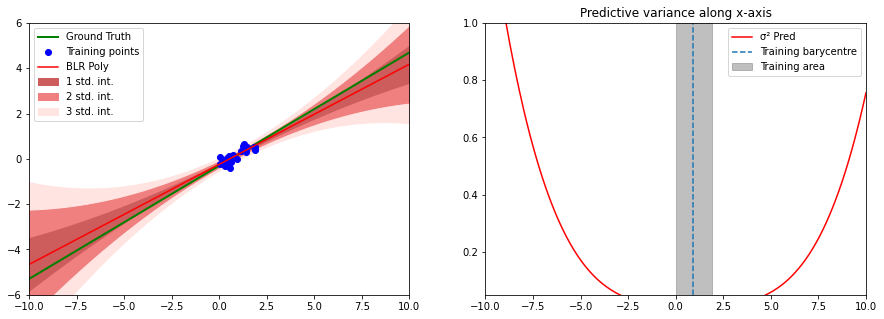

In [ ]:
#@title **[CODING TASK]** Predict on test dataset and visualize results { form-width: "20%" }

# ============ YOUR CODE HERE ============
# Predict test points and use visualization function
# defined at the beginning of the notebook
# You should use the following parameters for plot_results
# xmin=-10, xmax=10, ymin=-6, ymax=6, stdmin=0.05, stdmax=1

x_test = dataset_linear['X_test']

pred = np.array([np.array(f_pred(i)) for i in x_test])

y_pred = pred[:,0]
std_pred = pred[:,1]

plot_results(dataset_linear['X_train'], dataset_linear['y_train'], dataset_linear['X_test'], dataset_linear['y_test'], y_pred, std_pred,
                 xmin=-10, xmax=10, ymin=-6, ymax=6, stdmin=0.05, stdmax=1)

**[Question 1.4] Analyse these results. Describe the behavior of the predictive variance for points far from training distribution. Prove it analytically in the case where $\alpha=0$ and $\beta=1$.**

On peut voir qu'en raison de la concentration des points de train que l'estimation de la variance est de moins en moins précise plus on s'éloigne de nos données. Les zones rouges sont les zones dans lesquels on peut potentiellement trouver des points dans le futur avec les zones claires les moins probable. 
A droite on voit bien que la std grandi plus on est loin de nos training area

**Bonus Question: What happens when applying Bayesian Linear Regression on the following dataset?**

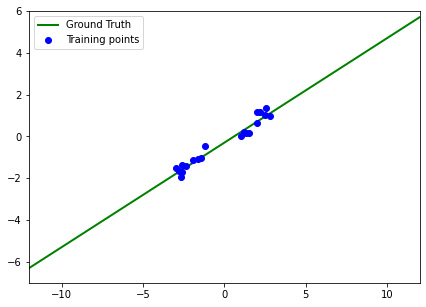

In [ ]:
# Create training and test points
dataset_hole = {}
dataset_hole['X_train'] = np.concatenate(([np.random.uniform(-3, -1, 10), np.random.uniform(1, 3, 10)]), axis=0)
dataset_hole['y_train'] = f_linear(dataset_hole['X_train'], noise_amount=1,sigma=SIG)
dataset_hole['X_test'] = np.linspace(-12,12, 100)
dataset_hole['y_test'] = f_linear(dataset_hole['X_test'], noise_amount=0,sigma=SIG)
dataset_hole['ALPHA'] = ALPHA
dataset_hole['BETA'] = 1/(2.0*SIG**2)

# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-12, xmax = 12)
plt.ylim(ymin = -7, ymax = 6)
plt.plot(dataset_hole['X_test'], dataset_hole['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_hole['X_train'], dataset_hole['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

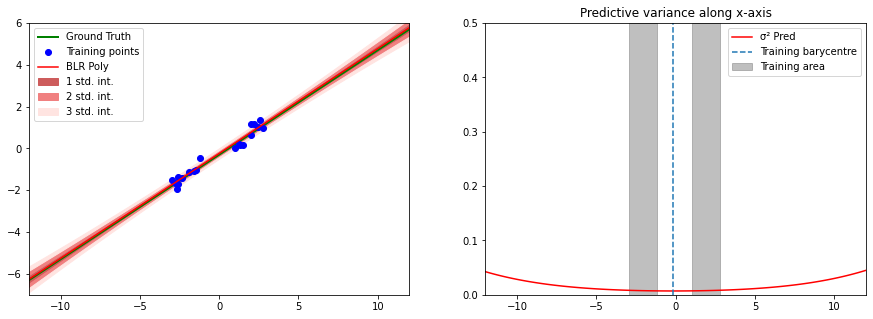

In [ ]:
#@title **[BONUS CODING TASK]** Define f_pred, predict on test points and plot results { form-width: "20%" }
# TO DO: Define f_pred, predict on test points and plot results

# ============ YOUR CODE HERE ============
# Define new f_pred, then predict test points 
# and use visualization function as before
# You should use the following parameters for plot_results
# xmin=-12, xmax=12, ymin=-7, ymax=6, stdmin=0.0, stdmax=0.5

f_pred = closed_form(phi_linear, dataset_hole['X_train'], dataset_hole['y_train'], 
                     dataset_hole['ALPHA'], dataset_hole['BETA'])

x_test = dataset_hole['X_test']

pred = np.array([np.array(f_pred(i)) for i in x_test])

y_pred = pred[:,0]
std_pred = pred[:,1]

plot_results(dataset_hole['X_train'], dataset_hole['y_train'], dataset_hole['X_test'], dataset_hole['y_test'], y_pred, std_pred,
                 xmin=-12, xmax=12, ymin=-7, ymax=6, stdmin=0.0, stdmax=0.5)


Ici, comme les points du train sont espacés on reste assez precis en s'éloignant. La précision descend moins vite

## Part II: Non Linear models

We now introduce a more complex toy dataset, which is an increasing sinusoidal curve. The goal of this part is to get insight on the importance of the chosen basis function on the predictive variance behavior.

In [ ]:
#@title Hyperparameters for non-linear model { form-width: "30%" }

SIG = 0.2 #@param
ALPHA = 0.05 #@param
NB_POINTS = 50 #@param
NB_POLYNOMIAL_FEATURES = 10 #@param
MU_MIN = 0 #@param
MU_MAX = 1 #@param
NB_GAUSSIAN_FEATURES = 9 #@param

In [ ]:
# Generate sinusoidal toy dataset
def f_sinus(x, noise_amount,sigma=0.2):
    y = np.sin(2*np.pi*x) + x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount * noise

# Create training and test points
dataset_sinus = {}
dataset_sinus['X_train'] = np.random.uniform(0, 1, NB_POINTS)
dataset_sinus['y_train'] = f_sinus(dataset_sinus['X_train'], noise_amount=1,sigma=SIG)
dataset_sinus['X_test'] = np.linspace(-1,2, 10*NB_POINTS)
dataset_sinus['y_test'] = f_sinus(dataset_sinus['X_test'], noise_amount=0,sigma=SIG)
dataset_sinus['ALPHA'] = ALPHA
dataset_sinus['BETA'] = 1/(2.0*SIG**2)

# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-1, xmax = 2)
plt.ylim(ymin = -2, ymax = 3)
plt.plot(dataset_sinus['X_test'], dataset_sinus['y_test'], color='green', linewidth=2,
         label="Ground Truth")
plt.plot(dataset_sinus['X_train'], dataset_sinus['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

### II.1 Polynomial basis functions

We will first use polynomial basis functions:
$$\phi:x \rightarrow 
  \begin{pmatrix}
    \phi_0 \\
    ... \\
    \phi_{D-1}
  \end{pmatrix}
$$
where $\phi_j = x^j$ for $j \geq 0$ and $D \geq 0$


Design matrix $\Phi$ defined on training set $\mathcal{D}$ is:
$$ \Phi=
  \begin{pmatrix}
    \phi(x_1)^T \\
    ... \\
    \phi(x_n)^T
  \end{pmatrix} =
  \begin{pmatrix}
    1 & x_1 & x_1^2 &... &x_1^{D-1} \\
    ... & ... & ... & ...\\
    1 & x_N & x_N^2 &... &x_N^{D-1}
  \end{pmatrix}
$$

In [ ]:
#@title **[CODING TASK]** Define basis function
def phi_polynomial(x):
    """ Polynomial Basis Functions
    
    Args:
      x: (float) scalar input
      
    Returns:
      (1D-array) polynomial features of x
    """
    
    # ============ YOUR CODE HERE ============
    return None

In [ ]:
#@title **[CODING TASK]** Implement closed form for polynomial features and visualise results

# ============ YOUR CODE HERE ============
# Define f_pred as the closed form for polynomial features
# with a sinusoidal dataset 
# Then, predict test points and use visualization function
# defined at the beginning of the notebook
# You should use the following parameters for plot_results
# xmin=-1, xmax=2, ymin=-3, ymax=5, stdmin=0, stdmax=10


**[Question 2.1] What can you say about the predictive variance?**

Predictive variance increase as we move away from training data. However here with polynomial features, the minimum is not the training barycentre anymore.

### II.2 Gaussian basis functions

Now, let's consider gaussian basis functions:
$$\phi:x \rightarrow 
  \begin{pmatrix}
    \phi_0 \\
    ... \\
    \phi_{D-1}
  \end{pmatrix}
$$
where $\phi_j = \exp \Big ( -\frac{(x-\mu_j)^2}{2s^2} \Big )$ for $j \geq 0$


Design matrix $\Phi$ defined on training set $\mathcal{D}$ is:
$$ \Phi=
  \begin{pmatrix}
    \phi_0(x_1) & \phi_1(x_1) &... &\phi_{D-1}(x_1) \\
    ... & ... & ... & ...\\
    \phi_0(x_N) & \phi_1(x_N) &... &\phi_{D-1}(x_N)
  \end{pmatrix}
  =
  \begin{pmatrix}
    e^{-\frac{(x_1-\mu_0)^2}{2s^2}} & e^{-\frac{(x_1-\mu_1)^2}{2s^2}} & ... & e^{-\frac{(x_1 - \mu_{D-1})^2}{2s^2}} \\
    ... & ... & ... & ...\\
    e^{-\frac{(x_N-\mu_0)^2}{2s^2}} & e^{-\frac{(x_N-\mu_1)^2}{2s^2}} &... & e^{-\frac{(x_N-\mu_{D-1})^2}{2s^2}} \\
  \end{pmatrix}  
$$

In [ ]:
#@title **[CODING TASK]** Define Gaussian basis function

def phi_gaussian(x) :
    """ Gaussian Basis Functions defined linearly between 
    MU_MIN (=mu_0) and MU_MAX (=mu_{D-1})
    
    Args:
      x: (float) scalar input
      
    Returns:
      (1D-array) gaussian features of x
    """
    s = (MU_MAX-MU_MIN)/ NB_GAUSSIAN_FEATURES

    # ============ YOUR CODE HERE ============
    return None

In [ ]:
#@title **[CODING TASK]** Implement closed form for Gausian features and visualise results

# ============ YOUR CODE HERE ============
# Define f_pred as the closed form for Gaussian features
# with a sinusoidal dataset 
# Then, predict test points and use visualization function
# defined at the beginning of the notebook
# You should use the following parameters for plot_results
# xmin=-1, xmax


**[Question 2.2] What can you say this time about the predictive variance? What can you conclude?**

**[Question 2.3] Explain why in regions far from training distribution, the predictive variance converges to this particular value when using localized basis functions such as Gaussians.**